In [1]:
train_kwargs = {
    "enc_arch": "resnet50",
    "enc_path": None,
    "classifier_type": "one_hot",
    "seed": 999,
    "cudnn_deterministic": False,
    "batch_size": 32,
    "num_workers": 1,
    "validation_ratio": 0.2,
    "fine_tune": True,
    "optimizer_name": "adamw",
    "lr": 0.001,
    "warmup_start_lr": 0.0001,
    "min_lr": 0.0001,
    "weight_decay": 0.0001,
    "scheduler_name": "warmup_cosine",
    "max_epochs": 10,
    "warmup_epochs": 5,
    "save_model": True,
    "save_curves": True,
    "use_benthicnet_normalization": False,
    "descendent_matrix_path": "./cfg/hierarchy/descendent_matrix.npy",
    "descendent_matrix": None,
    "hierarchy_dict_path": "./cfg/hierarchy/hierarchy_dict.json",
    "hierarchy_dict": None,
    "custom_trained": True,
    "num_classifiers": 10,
}

In [2]:
from types import SimpleNamespace

import json
import numpy as np
import pandas as pd
import torch

from utils.cost_weighted_ce import CostWeightedCELossWithLogits, CalcDistance
from utils.dataset import FathomNetDataset
from utils.utils import build_model, df_split, get_augs, \
    map_label_to_idx, set_seed, collect_hierarchy, \
    convert_indices_to_label, get_cost_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_kwargs = SimpleNamespace(**train_kwargs)

# Set seed for reproducibility
set_seed(train_kwargs.seed, cudnn_deterministic=train_kwargs.cudnn_deterministic)

is_hml = train_kwargs.classifier_type == "hml"

df = pd.read_csv("./data/train/annotations.csv")
test_df = pd.read_csv("./data/test/annotations.csv")

df, label_map = map_label_to_idx(df, "label")

label_col = "label_idx"
if is_hml:
    label_map = json.load(
        open("./data/train/index_to_taxon.json", "r")
    )
    assert train_kwargs.hierarchy_dict_path is not None, (
        "hierarchy_dict_path must be specified for HML classifier."
    )
    train_kwargs.hierarchy_dict = json.load(
        open(train_kwargs.hierarchy_dict_path, "r")
    )
    
    label_col = "label_hml"
    df[label_col] = df.apply(collect_hierarchy, axis=1)
    df[label_col] = df[label_col].apply(convert_indices_to_label)

train_df, val_df = df_split(
    df, validation_ratio=train_kwargs.validation_ratio, seed=train_kwargs.seed
)

train_augs, val_augs = get_augs(
    colour_jitter=False, 
    use_benthicnet=train_kwargs.use_benthicnet_normalization
    )

train_dataset = FathomNetDataset(
    df=train_df, 
    label_col=label_col,
    transform=train_augs,
    )

train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_kwargs.batch_size,
        shuffle=True,
        num_workers=train_kwargs.num_workers,
        pin_memory=True,
        drop_last=True,
    )

if train_kwargs.validation_ratio > 0:
    val_dataset = FathomNetDataset(
        df=val_df, 
        label_col=label_col,
        transform=val_augs,
        )

    val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=train_kwargs.batch_size,
            shuffle=False,
            num_workers=train_kwargs.num_workers,
            pin_memory=True
        )
else:
    val_dataset = []
    val_dataloader = None

test_dataset = FathomNetDataset(
    df=test_df, 
    label_col=label_col,
    transform=val_augs,
    is_test=True,
    )

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=train_kwargs.batch_size,
        shuffle=False,
        num_workers=train_kwargs.num_workers,
        pin_memory=True
    )

print("Total samples:", len(df))
print(len(train_dataset), f"training samples, {len(train_dataset)/len(df):.2%} of total")
print(len(val_dataset), f"validation samples, {len(val_dataset)/len(df):.2%} of total")

train_kwargs.steps_per_epoch = len(train_dataloader)

if "one_hot" in train_kwargs.classifier_type:
    metric_cost_matrix = get_cost_matrix(
            mode="cce"
        ).to(device)
    dist_metric = CalcDistance(
        cost_matrix=metric_cost_matrix,
    )
    output_dim = len(label_map)
    criterion = torch.nn.CrossEntropyLoss()
    if train_kwargs.classifier_type != "one_hot":
        mode = train_kwargs.classifier_type.split("_")[2]
        cost_matrix = get_cost_matrix(
            mode=mode
        ).to(device)
        criterion = CostWeightedCELossWithLogits(
            cost_matrix=cost_matrix,
        )
elif is_hml:
    assert train_kwargs.descendent_matrix_path is not None, (
        "descendent_matrix_path must be specified for HML classifier."
    )
    descendent_matrix = torch.from_numpy(
        np.load(train_kwargs.descendent_matrix_path)
    ).to(device)
    output_dim = descendent_matrix.shape[0]
    train_kwargs.descendent_matrix = descendent_matrix
    criterion = torch.nn.BCELoss()
else:
    raise ValueError("Unsupported classifier type.")

model = build_model(
    encoder_arch=train_kwargs.enc_arch,
    encoder_path=train_kwargs.enc_path,
    classifier_type=train_kwargs.classifier_type,
    num_classifiers=train_kwargs.num_classifiers,
    requires_grad=train_kwargs.fine_tune,
    custom_trained=train_kwargs.custom_trained,
    output_dim=output_dim,
)

model = model.to(device)

Total samples: 23699
18960 training samples, 80.00% of total
4739 validation samples, 20.00% of total
No encoder weights loaded.


Epoch [1/10], Loss: 27.9342, Accuracy: 31.24%, Avg. Confidence: 0.22 Avg. Distance: 5.70
Validation Loss: 12.6052, Validation Accuracy: 54.44% Avg. Confidence: 0.42 Avg. Distance: 3.27
Epoch [2/10], Loss: 16.2172, Accuracy: 48.15%, Avg. Confidence: 0.30 Avg. Distance: 4.84
Validation Loss: 10.9562, Validation Accuracy: 57.06% Avg. Confidence: 0.40 Avg. Distance: 3.12
Epoch [3/10], Loss: 12.5100, Accuracy: 54.34%, Avg. Confidence: 0.34 Avg. Distance: 4.38
Validation Loss: 9.5099, Validation Accuracy: 60.08% Avg. Confidence: 0.44 Avg. Distance: 2.87
Epoch [4/10], Loss: 10.7754, Accuracy: 56.78%, Avg. Confidence: 0.36 Avg. Distance: 4.10
Validation Loss: 8.7670, Validation Accuracy: 60.84% Avg. Confidence: 0.43 Avg. Distance: 2.83
Epoch [5/10], Loss: 9.8391, Accuracy: 58.32%, Avg. Confidence: 0.38 Avg. Distance: 3.89
Validation Loss: 8.4002, Validation Accuracy: 61.89% Avg. Confidence: 0.45 Avg. Distance: 2.69
Epoch [6/10], Loss: 9.1784, Accuracy: 59.48%, Avg. Confidence: 0.39 Avg. Distan

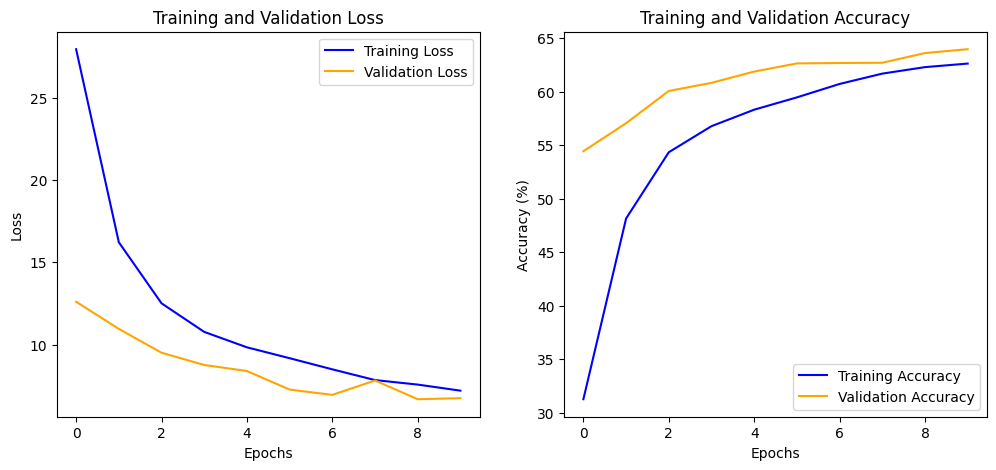

In [3]:
from utils.utils import train

train(
    model=model, 
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    test_loader=test_dataloader,
    label_map=label_map,
    criterion=criterion,
    dist_metric=dist_metric,
    device=device,
    train_kwargs=train_kwargs,
    )